<a href="https://colab.research.google.com/github/MinahilSadiq1/Classification_of_corn_using_RandomForest/blob/main/randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geemap

In [2]:
import geemap
import folium

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

In [4]:
#loading sentinel 2
sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR")
#district boundaries
district_boundary_table = ee.FeatureCollection("projects/ee-sp20-bcs-023/assets/boundaries_file-polygon")
#this boundaries_file-polygon creates boundaries for all over the pakistan map.
#alpha farm fields
corn_map = ee.FeatureCollection("projects/ee-sp20-bcs-023/assets/AlfaFarmsMaizeLand")
#AlfaFarmsMaizeLand is a dataset of corn area
# Load the corn and other feature collections
corn = ee.FeatureCollection("projects/ee-sp20-bcs-023/assets/alpha_corn")
other = ee.FeatureCollection("projects/ee-sp20-bcs-023/assets/classified_noncorn")

In [5]:
# Define the region of interest .. KASUR
district_boundary = district_boundary_table.filter(ee.Filter.eq('DISTRICT', 'KASUR')).geometry()
gt = corn.merge(other)

In [6]:
def addNDVIBand(image):
  # calculate NDVI for input images using B8(Near Infrared) and B4(RED) bands
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    # Green Normalized Difference Vegetation Index using band B8 and B3(Green)
    gndvi = image.normalizedDifference(['B8', 'B3']).rename('GNDVI')
    #Enhanced Vegetation Index using B8, B4, B2(BLUE)
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }
    ).rename('EVI')
    #returning original image with three bands
    return image.addBands([ndvi, gndvi, evi])



In [7]:
#collection dates 01-01-2023 to 01-06-2023
collection_dates = ['2023-01-01','2023-01-15','2023-02-01','2023-02-15','2023-03-01','2023-03-15','2023-04-01','2023-04-15','2023-05-01','2023-05-15','2023-06-01']

In [ ]:
#an empty list
feature_data = []
#loop iterates from 0 to one lesss than collection dates
for i in range(0, len(collection_dates)-1):
    print(i)

    #start and end date for specific time periods
    start_date = collection_dates[i]
    end_date = collection_dates[i+1]

    #counter variable used to assign unique variable
    point_id_counter = 1

    #filtering image collection that fall whithin specific time period and boundary defined
    collection = sentinel2.filterDate(start_date, end_date).filterBounds(district_boundary)

    #calculating vegetation indecis for eaxh image
    collection = collection.map(addNDVIBand)

    #calculates the median value for each band across all images & selecting specific bands
    #of interest, including Sentinel-2 spectral bands and (NDVI, EVI, GNDVI)
    collection_image = collection.median().select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B11', 'B12', 'NDVI', 'EVI', 'GNDVI'])

    #extracting features for analysis , at the scale of 10 meters
    extracted_features = collection_image.sampleRegions(
    collection = gt,
    properties = ['class'],
    scale=10
    )

    #creating new feature collection containing label property copied from class
    featureCollection = extracted_features.map(lambda feature: ee.Feature(None, {'label': feature.get('class')}).copyProperties(feature))

    # Calculate the total number of features in the FeatureCollection
    total_count = extracted_features.size().getInfo()
    print("total counts are: ", total_count)

    # Calculate the number of features in each split
    split_count = int(total_count / 10)

    # Create a list to store the splits
    splits = []

    # Iterate over 10 partitions
    for i in range(1, 11):
        # Calculate the starting and ending index for each split
        start_index = (i - 1) * split_count
        end_index = i * split_count;
        # print("start index are: ",start_index);
        # print("end are: ",end_index);

        # Filter the FeatureCollection to get the current split, to get the list format
        split = extracted_features.toList(split_count, start_index)
        splits.append(split);

    print("----------------Date: ",start_date,"-----------------");

    for split in splits:
      #getInfo used to convert to the python list
      # .getInfo() method retrieves the information from the Earth Engine object and makes it
      # available for Python-native processing
        split_list = split.getInfo()
        for data in split_list:
          # 'data' is a single feature in split
            dictionary = data['properties']
            dictionary['Date'] = start_date
            dictionary['Point ID'] = point_id_counter
            # print("dict:", dictionary)
            feature_data.append(dictionary)
            point_id_counter = point_id_counter + 1


    print("At the end, Point ID is: ",point_id_counter)
    # In essence, this code processes the features in each split, enriches
    # them with additional attributes (Date and Point ID), and collects them into a list (feature_data) for further use.


In [ ]:
#extracted features
feature_data

In [10]:
#creating csv file from above features
import csv

# Specify the CSV file name
csv_file = 'data_features.csv'

# Extract the keys from the first dictionary to use as column headers
fieldnames = feature_data[0].keys()

# Write the data to the CSV file
with open(csv_file, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write the header row
    writer.writeheader()

    # writes each dictionary row as a row in the CSV file, with values corresponding to the column headers.
    for row in feature_data:
        writer.writerow(row)

print(f'CSV file "{csv_file}" has been created.')


CSV file "data_features.csv" has been created.


In [11]:
# importing required libraries
import pandas as pd
import numpy as np
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#reading a file
data = pd.read_csv('data_features.csv')

In [12]:
# 1. Preprocessing of data
# Converting "Date" to proper date format
data['Date'] = pd.to_datetime(data['Date'])


In [13]:
#index column "date"
data.index = data.pop('Date')

In [14]:
data

,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B9,EVI,GNDVI,NDVI,class,Point ID
Date,,,,,,,,,,,,,,,,
2023-01-01,6217.0,5793.0,4852.0,5620.0,5728.0,5916.0,6199.0,6346.0,6341.0,6416.0,6864.0,-2.062857,0.056653,0.040545,1,1
2023-01-01,6217.0,5793.0,4852.0,5609.0,5624.0,5792.0,6199.0,6346.0,6341.0,6260.0,6864.0,-1.109531,0.053517,0.038832,1,2
2023-01-01,6217.0,5734.0,4764.0,5664.0,5628.0,5768.0,6161.0,6280.0,6301.0,6396.0,6864.0,-1.064407,0.063872,0.051628,1,3
2023-01-01,6217.0,5734.0,4764.0,5584.0,5676.0,5812.0,6161.0,6280.0,6301.0,6448.0,6864.0,-0.814460,0.063675,0.051876,1,4
2023-01-01,6050.0,5947.0,4956.0,5936.0,5876.0,6128.0,6555.0,6642.0,6563.0,6640.0,6886.0,-0.901933,0.061042,0.040100,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15,1750.0,4384.0,3912.0,2158.0,2622.0,2942.0,3270.0,3665.0,3952.0,4020.0,3924.0,0.587702,0.215603,0.165390,0,10646
2023-05-15,1750.0,4669.0,4239.0,2312.0,2752.0,3160.0,3436.0,3782.0,4044.0,4116.0,3924.0,0.461760,0.198602,0.138979,0,10647
2023-05-15,1750.0,4669.0,4239.0,2312.0,2752.0,3160.0,3436.0,3782.0,4044.0,4116.0,3924.0,0.461760,0.198602,0.138979,0,10648


In [35]:
# Split data into features (X) and labels (y)
X = data.drop(['class', 'Point ID'], axis=1).values
y = data['class'].values


# Split the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_rf = scaler.fit_transform(X_train_rf)
X_test_rf = scaler.transform(X_test_rf)

# Initialize and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, oob_score=True)
rf_model.fit(X_train_rf, y_train_rf)

RandomForestClassifier(oob_score=True)

In [36]:
predictions = rf_model.predict(X_test_rf)

In [37]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy
accuracy = accuracy_score(y_test_rf, predictions)

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.95%


In [48]:
# Sample a random instance
random_data = data.sample().drop(['class', 'Point ID'], axis=1)

# Prepare the data
random_data_array = random_data.values.reshape(1, -1)
random_data_transformed = scaler.transform(random_data_array)  # Standardize the data if needed

# Make a prediction
prediction = rf_model.predict(random_data_transformed)

print(f"Predicted Class: {prediction[0]}")

# If you want to see the actual class (for verification)
actual_class = data.loc[random_data.index, 'class'].values[0]
print(f"Actual Class: {actual_class}")


Predicted Class: 1
Actual Class: 1


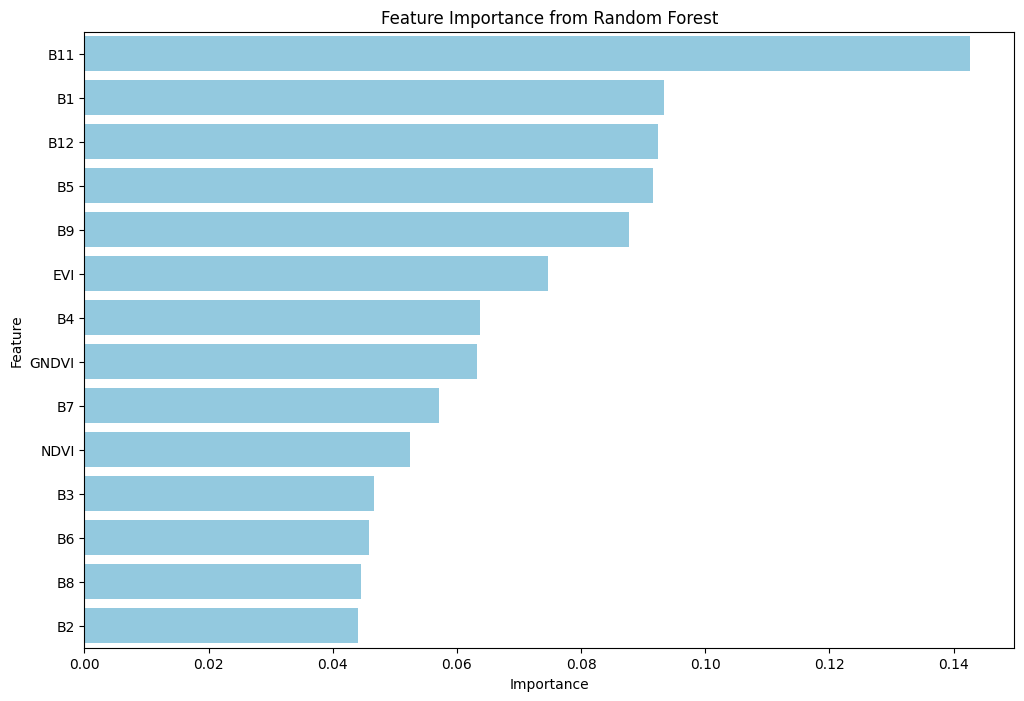

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = rf_model.feature_importances_

# Get the feature names (assuming they are the column names of the original data without 'class' and 'Point ID')
feature_names = data.drop(['class', 'Point ID'], axis=1).columns

# Create a DataFrame to hold the importances and feature names
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color='skyblue')
plt.title('Feature Importance from Random Forest')
plt.show()
